In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys # used in command to make entire array print by default

# Modeling
import xgboost as xgb
from sklearn.decomposition import PCA

In [2]:
df = acquire_oil()
df = prep_data(df)
df.shape

(14297, 36)

# Analyze Data

## Summarize Data

### Data Structure

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14297 entries, 0 to 19495
Data columns (total 36 columns):
api14                 14297 non-null int64
lease_name            14297 non-null object
well_number           14297 non-null object
county                14297 non-null object
type                  14297 non-null category
status                14297 non-null category
oper                  14297 non-null object
multi_well_lease      14297 non-null object
major_phase           14297 non-null category
formation             14283 non-null object
proppant_ppf          11109 non-null float64
prod_method           14297 non-null category
frac_fluid_gpf        12632 non-null float64
lateral_len           14297 non-null float64
frac_stages           13203 non-null float64
frac_fluid_type       14137 non-null category
first_prod            14297 non-null datetime64[ns]
last_prod             14297 non-null datetime64[ns]
oil_gravity           13960 non-null float64
peak_boepd            14297 no

In [4]:
df.sample(10)

,api14,lease_name,well_number,county,type,status,oper,multi_well_lease,major_phase,formation,...,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,lateral_class,vintage
12634,42383305090000,UNIVERSITY 5,1,REAGAN,Vertical,Inactive,APACHE CORPORATION,True,OIL,SPRABERRY LOWER,...,-101.588965,154705,31.290399,-101.588965,0.345667,0.509833,14,24.690476,one,2005
6266,42235354080000,SUGG 4948,H 53M,IRION,Horizontal,Active,APACHE CORPORATION,True,OIL,WOLFCAMP,...,-101.107181,143755,31.264006,-101.106692,187.957506,26.134247,64,2936.836030,eight,2013
2148,42115324070100,WEST WELCH UNIT,1804,DAWSON,Horizontal,Active,OXY USA WTP LP,True,OIL,SAN ANDRES,...,-102.195574,141706,32.910088,-102.201146,78.388839,21.307105,384,204.137602,four,1987
3969,42173371910000,FLANAGAN 14-LLOYD B,11H,GLASSCOCK,Horizontal,Active,PIONEER NATURAL RESOURCES USA INC,True,OIL,SPRABERRY,...,-101.757573,144467,32.014341,-101.754558,203.258178,20.265023,37,5493.464261,eleven,2016
6762,42301317540000,TOM MCKNIGHT 21,2H,LOVING,Horizontal,Active,SHELL WESTERN E & P INCORPORATED LP,False,GAS,BONE SPRING,...,-103.652691,146949,31.948753,-103.652366,260.012350,62.835271,79,3291.295565,five,2012
11912,42371389580000,BELLE,1H,PECOS,Horizontal,Inactive,HALCON OPERATING CO INC,False,OIL,WOLFCAMP,...,-103.229750,149485,31.076915,-103.229997,102.635667,26.236111,60,1710.594444,four,2012
15328,42383399580000,BOLD WTG 4-232 A 2HL,2BL,REAGAN,Horizontal,Inactive,BOLD OPERATING LLC,False,OIL,WOLFCAMP,...,-101.352503,100340,31.161660,-101.352785,33.541500,3.244173,0,inf,eleven,2018
2521,42169340180000,BASINGER-LONG UNIT,H 9B,GARZA,Horizontal,Active,BROWN GEORGE R PARTNERSHIP LP THE,True,OIL,SAN ANDRES,...,-101.488267,145006,33.314605,-101.487222,36.108167,35.296351,100,361.081668,two,2010
9372,42329356150000,BRAUN B,802,MIDLAND,Vertical,Inactive,ENDEAVOR ENERGY RESOURCES LP,True,OIL,SPRABERRY,...,-102.041900,154878,31.723800,-102.041900,36.236833,16.220606,129,280.905685,three,2007
13000,42383349990000,SRH A,2501,REAGAN,Vertical,Inactive,ENDEAVOR ENERGY RESOURCES LP,True,OIL,SPRABERRY UPPER,...,-101.406110,153887,31.419392,-101.406110,58.442167,23.892954,174,335.874521,three,1999


### Data Distributions

In [5]:
print (df.apply(lambda x: x.nunique()))

api14                 14110
lease_name             6436
well_number            4699
county                   52
type                      2
status                    2
oper                    499
multi_well_lease          2
major_phase               3
formation               158
proppant_ppf          10908
prod_method               9
frac_fluid_gpf        12110
lateral_len            6503
frac_stages              65
frac_fluid_type          10
first_prod              613
last_prod               420
oil_gravity             191
peak_boepd            13442
oil_hist              13836
gas_hist              13890
gor_hist              14289
ip90_boeqpd           13905
landing_depth          5523
sur_lat               13739
sur_long              13931
well_id               14297
mid_point_lat         14024
mid_point_long        14040
recovery              14269
recovery_per_foot     14287
months_active           548
recovery_per_month    14175
lateral_class            14
vintage             

In [6]:
df.describe()

,api14,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,...,sur_lat,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,vintage
count,1.429700e+04,1.110900e+04,1.263200e+04,14297.000000,13203.000000,13960.000000,14297.000000,14297.000000,14297.000000,14297.000000,...,14297.000000,14297.000000,14297.000000,14297.000000,14297.000000,14297.000000,14297.000000,14297.000000,1.429700e+04,14297.000000
mean,4.223232e+13,2.499204e+03,2.270947e+03,4443.440652,2.345073,2.369823,433.740066,117.086335,353.242238,3624.301360,...,31.736101,-102.155881,140657.269917,31.736377,-102.155979,156.055703,293.039255,83.639785,inf,2008.667483
std,9.252502e+11,7.812709e+04,7.224982e+04,3089.087568,7.953784,10.532518,458.011561,114.420155,439.191482,3682.282923,...,0.524086,0.817203,19192.812195,0.523980,0.817180,171.938594,2895.222528,95.717628,NaN,10.793734
min,3.000521e+13,2.531144e-01,0.000000e+00,1.000000,0.000000,0.000000,0.071233,0.002000,0.000000,0.000000,...,30.447167,-104.359908,22866.000000,30.447167,-104.360243,0.000000,0.000000,0.000000,0.000000e+00,1955.000000
25%,4.221936e+13,3.482957e+02,1.712004e+02,1630.000000,0.000000,0.000000,67.035980,28.539000,57.216000,1312.190670,...,31.406698,-102.664381,142462.000000,31.407263,-102.663134,37.704000,14.652151,34.000000,4.863663e+02,2007.000000
50%,4.232935e+13,1.088509e+03,8.869065e+02,4295.000000,0.000000,0.000000,300.007141,87.090000,214.011000,2338.714840,...,31.673731,-101.947675,147071.000000,31.673682,-101.948124,109.699171,26.292243,54.000000,1.946157e+03,2013.000000
75%,4.238339e+13,1.529274e+03,1.539325e+03,7196.000000,0.000000,0.000000,666.672200,171.421000,483.086000,4528.504000,...,31.975031,-101.545642,151976.000000,31.978158,-101.546233,198.150333,53.802927,84.000000,4.349252e+03,2015.000000
max,4.250137e+13,7.646000e+06,7.497903e+06,13815.000000,70.000000,68.000000,9358.215000,1659.710000,4692.163000,19977.940000,...,33.834820,-100.689460,157521.000000,33.836550,-100.691821,999.305470,122724.254500,747.000000,inf,2018.000000


In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
# makes entire array print by default, 
# can add [:##] to end to set length
np.set_printoptions(threshold=sys.maxsize)

In [9]:
len(df.columns) # 31 features

36

## Visualize Data

In [10]:
xgb_df = df.select_dtypes('number')
xgb_df.drop(columns=['oil_hist', 'api14', 'well_id', 'sur_long', 'sur_lat', 'mid_point_lat', 'mid_point_long'], inplace=True)
xgb_df.sample(3)

,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,gas_hist,gor_hist,ip90_boeqpd,landing_depth,recovery,recovery_per_foot,months_active,recovery_per_month,vintage
14018,811.5725,878.700100,7862.0,0.0,0.0,371.925323,281.528,2154.11700,339.007477,8093.0,157.464668,20.028576,61,2581.388003,2014
18612,325.3877,394.245453,4514.0,0.0,0.0,1280.450810,984.371,2029.05359,790.661100,10940.0,960.677650,212.821810,97,9903.893299,2011
18685,572.5389,554.024600,3088.0,0.0,0.0,791.653700,330.823,1717.17834,530.625900,10837.0,219.413513,71.053599,84,2612.065629,2012


In [11]:
df.columns

Index(['api14', 'lease_name', 'well_number', 'county', 'type', 'status',
       'oper', 'multi_well_lease', 'major_phase', 'formation', 'proppant_ppf',
       'prod_method', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'frac_fluid_type', 'first_prod', 'last_prod', 'oil_gravity',
       'peak_boepd', 'oil_hist', 'gas_hist', 'gor_hist', 'ip90_boeqpd',
       'landing_depth', 'sur_lat', 'sur_long', 'well_id', 'mid_point_lat',
       'mid_point_long', 'recovery', 'recovery_per_foot', 'months_active',
       'recovery_per_month', 'lateral_class', 'vintage'],
      dtype='object')

In [12]:
xgb_df.columns

Index(['proppant_ppf', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gas_hist', 'gor_hist', 'ip90_boeqpd',
       'landing_depth', 'recovery', 'recovery_per_foot', 'months_active',
       'recovery_per_month', 'vintage'],
      dtype='object')

### Attribute Histograms

#### XGBoost Feature Recommender

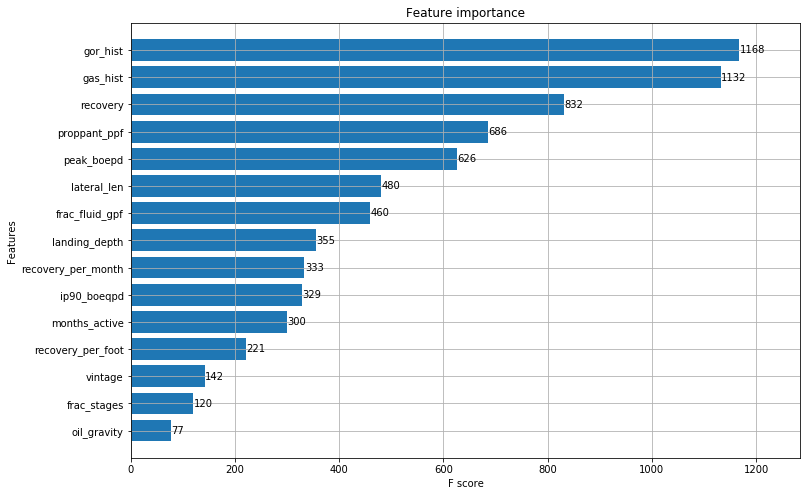

In [13]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

####  PCA (Principal Component Analysis) Feature Recommender

### Pairwise Scatterplots of Attributes